# XGBoost model
eXtreme Gradient Boosting ([XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md)) is an implementation of gradient boosted decision trees designed for speed and performance.
This notebook implements the final model of XGBoost used in our analysis.
Since it was not easy to integrate our custom evaluation function (BIP_error), we tried to minimize many built-in evaluation metrics of the XGBoost library (mae, rmse..), and then used the one that produced the best results in term of BIP_error, which in this case was rmse.

#### Feature selection
The feature selection was performed both by using the feature_selection library of SciKitLearn and by increasingly excluding the least important features that were detected by the model and plot after the training of the model

#### Hyperparameters Tuning
The tuning of the Hyperparameters for XGBoost was done using the RandomizedSearchCV method and using SciKitLearn wrapper of XGBoost (XGBRegressor) with a 5-fold cross-validation on 30% of the train test and providing it the parameters: gamma, learning_rate, max_depth, reg_alpha onto which apply the Grid Search. The best parameters it found were: {'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}, however, testing the parameters with our train-test split policy did not produce better results than the parameters found by manually try some combinations, thus, in the end we modified them.

#### Train-test split
Initially we split train and test sets with the train_test_split in model_selection of SciKitLearn, the results were too optimistic and then we decided to split in a way that would result in having a test set similar to the one we were going to be evaluated on, so we selected some test sets a pair of months in the 24 months of the train, in particular we concentrated on the pairs that seemed more significant in our analysis based on the real test we would have had to predict in the end which are:
* January and February 2018
* March and April 2017
* March and April 2016

The first one because it is the last 2 months we have and in a way this captures the real test set we have to predict, the other two were chosen because the real test set is for March and April.



In [1]:
# reoder variables to work on train or test dataset
predict_for_submission = True
predict_for_submission = False

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline

from RMSE import rmspe,rmspe_xg
import modify_dataset as md

In [3]:
df = pd.read_csv('./dataset/preprocessed_train_PCA.csv')

if predict_for_submission:
    df_test = pd.read_csv('dataset/preprocessed_test_PCA.csv')

In [4]:
df = df.drop(['NumberOfCustomers'], axis=1)
#OHE attr.
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)
#only for pca dataset
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
if predict_for_submission:
    train = df
    test = df_test
else:
    test_months = (1, 2)
    test_year = 2018

    train = md.get_fake_train(df, test_months, test_year)
    test = md.get_fake_test(df, test_months, test_year)

print('df.shape    ', df.shape)
print('train.shape ', train.shape)
print('test.shape  ', test.shape)

df.shape     (433958, 44)
train.shape  (397047, 44)
test.shape   (36911, 44)


### Selecting predictive features 

In [6]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('D_DayOfweek')
features.remove('Date')
features.remove('MeanRegionCustomers')

features.remove('p11')
features.remove('p12')
features.remove('p7')
features.remove('p9')
#4.5%

features.remove('p8')
features.remove('p10')
#4.2%
print("features:")

pprint(features)

features:
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'MeanCustomers',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6']


### SciKitLearn feature selection

In [7]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


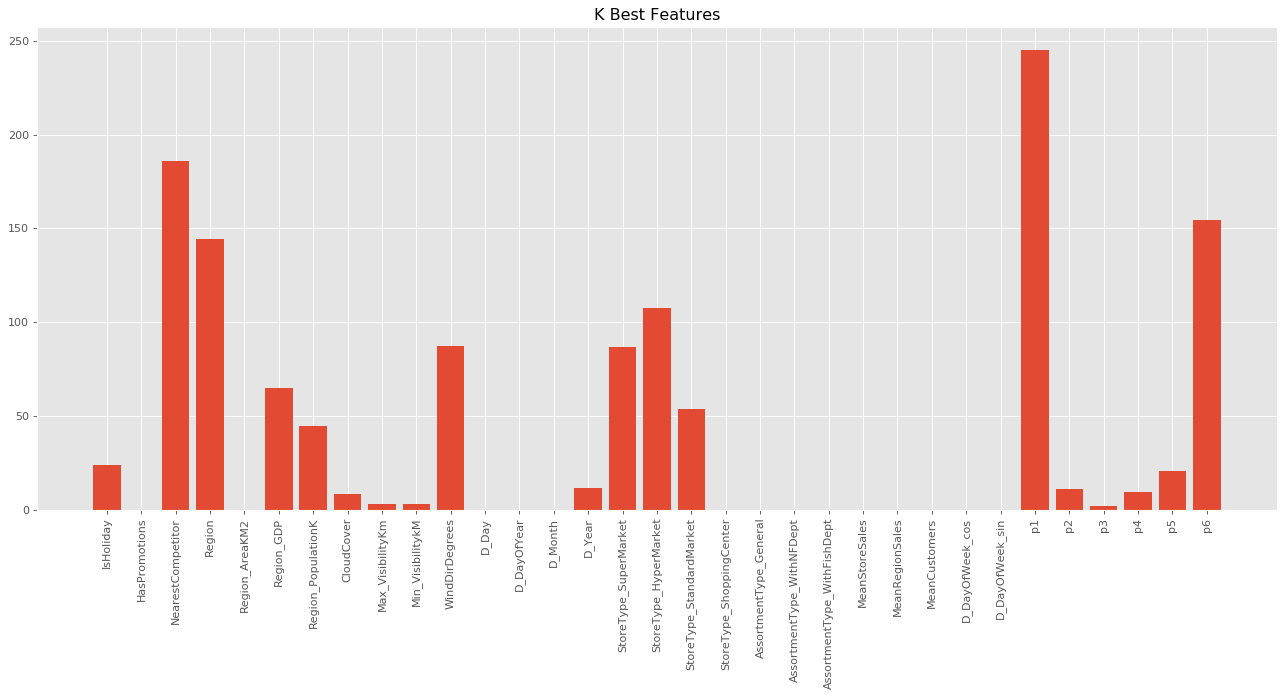

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# Perform feature selection
selector = SelectKBest(f_regression, k=20)
selector.fit(train[features], train['NumberOfSales'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores for each feature 
plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.title('K Best Features')
plt.show()

## Hyperparameters tuning (it takes a lot of time)

In [9]:
#from xgboost.sklearn import XGBRegressor # wrapper
## XGB with sklearn wrapper
## the same parameters as for xgboost model
#params_sk = {'max_depth': 8, 
#            'n_estimators': 100, # the same as num_rounds in xgboost
#            'objective': 'reg:linear', 
#            'subsample': 1.0, 
#            'colsample_bytree': 0.3, 
#            'learning_rate': 0.1, 
#            'seed': 23}     
#
#skrg = XGBRegressor(**params_sk)
#
#skrg.fit(X_train[features], np.log(X_train["NumberOfSales"] + 1))

In [10]:
#import scipy.stats as st
#
#params_grid = {  
#    'learning_rate': st.uniform(0.001, 0.2),
#    'max_depth': list(range(6, 20, 2)),
#    'gamma': st.uniform(0, 40),
#    'reg_alpha': st.expon(0, 40)}
#
#search_sk = RandomizedSearchCV(skrg, params_grid, cv = 3, verbose=2) # 3 fold cross validation
#search_sk.fit(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#
## best parameters
#print(search_sk.best_params_); print(search_sk.best_score_)

### Hyperparameters tuning result
The result was obtained using 0.3 of the train set (22 months) at random.
#### Result
{'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}
0.8171277539145538

DMatrix of train and test, NumberOfSales transformes to log + 1 to improve prediction result

In [11]:
dtrain = xgb.DMatrix(train[features], np.log(train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(test[features], np.log(test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [12]:
#Using tuned params
params = {"objective": "reg:linear",
          "eta": 0.2,   #0.17
          "max_depth": 5,
          "subsample": 0.8,  #0.8
          "colsample_bytree": 0.3, #0.3 #0.2
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          "gamma": 0.5, #2
          #"seed": 23,
          #"reg_alpha": 2  #4
          #"gamma": 14.5573974470,  #added as a test
          "reg_alpha": 1
          }

#reg_alpha 
#reg_lambda
num_trees = 100 #400

In [13]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.31677	train-rmse:6.33726
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.04646	train-rmse:5.07506
[2]	test-rmse:4.03896	train-rmse:4.06628
[3]	test-rmse:3.23186	train-rmse:3.25648
[4]	test-rmse:2.58994	train-rmse:2.61302
[5]	test-rmse:2.07296	train-rmse:2.09877
[6]	test-rmse:1.66991	train-rmse:1.6897
[7]	test-rmse:1.34583	train-rmse:1.36537
[8]	test-rmse:1.08731	train-rmse:1.10792
[9]	test-rmse:0.889825	train-rmse:0.906276
[10]	test-rmse:0.729554	train-rmse:0.747042
[11]	test-rmse:0.605429	train-rmse:0.624888
[12]	test-rmse:0.511182	train-rmse:0.53192
[13]	test-rmse:0.423297	train-rmse:0.44419
[14]	test-rmse:0.356297	train-rmse:0.377131
[15]	test-rmse:0.317964	train-rmse:0.337783
[16]	test-rmse:0.286211	train-rmse:0.306104
[17]	test-rmse:0.264902	train-rmse:0.283842
[18]	test-rmse:0.248371	train-rmse:0.266878
[19]	test-rmse:0.225123	train-rmse:0.242399
[20]	t

### Plotting Trees

In [14]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [40.0,20.0]
plt.rcParams['figure.dpi']=400
plt.rcParams.update({'font.size': 30})

In [15]:
from xgboost import plot_tree


In [16]:
xgb.to_graphviz(gbm, num_trees=1, rankdir='LR', **{'size':str(20)})

ImportError: You must install graphviz to plot tree

### Validating

In [17]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, test['NumberOfSales'].values)
print('error', error)

Validating
error 0.20657113247853362


RMSE

## Feature importance analysis:

In [18]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [30.0,16.0]
plt.rcParams['figure.dpi']=200
plt.rcParams.update({'font.size': 24})

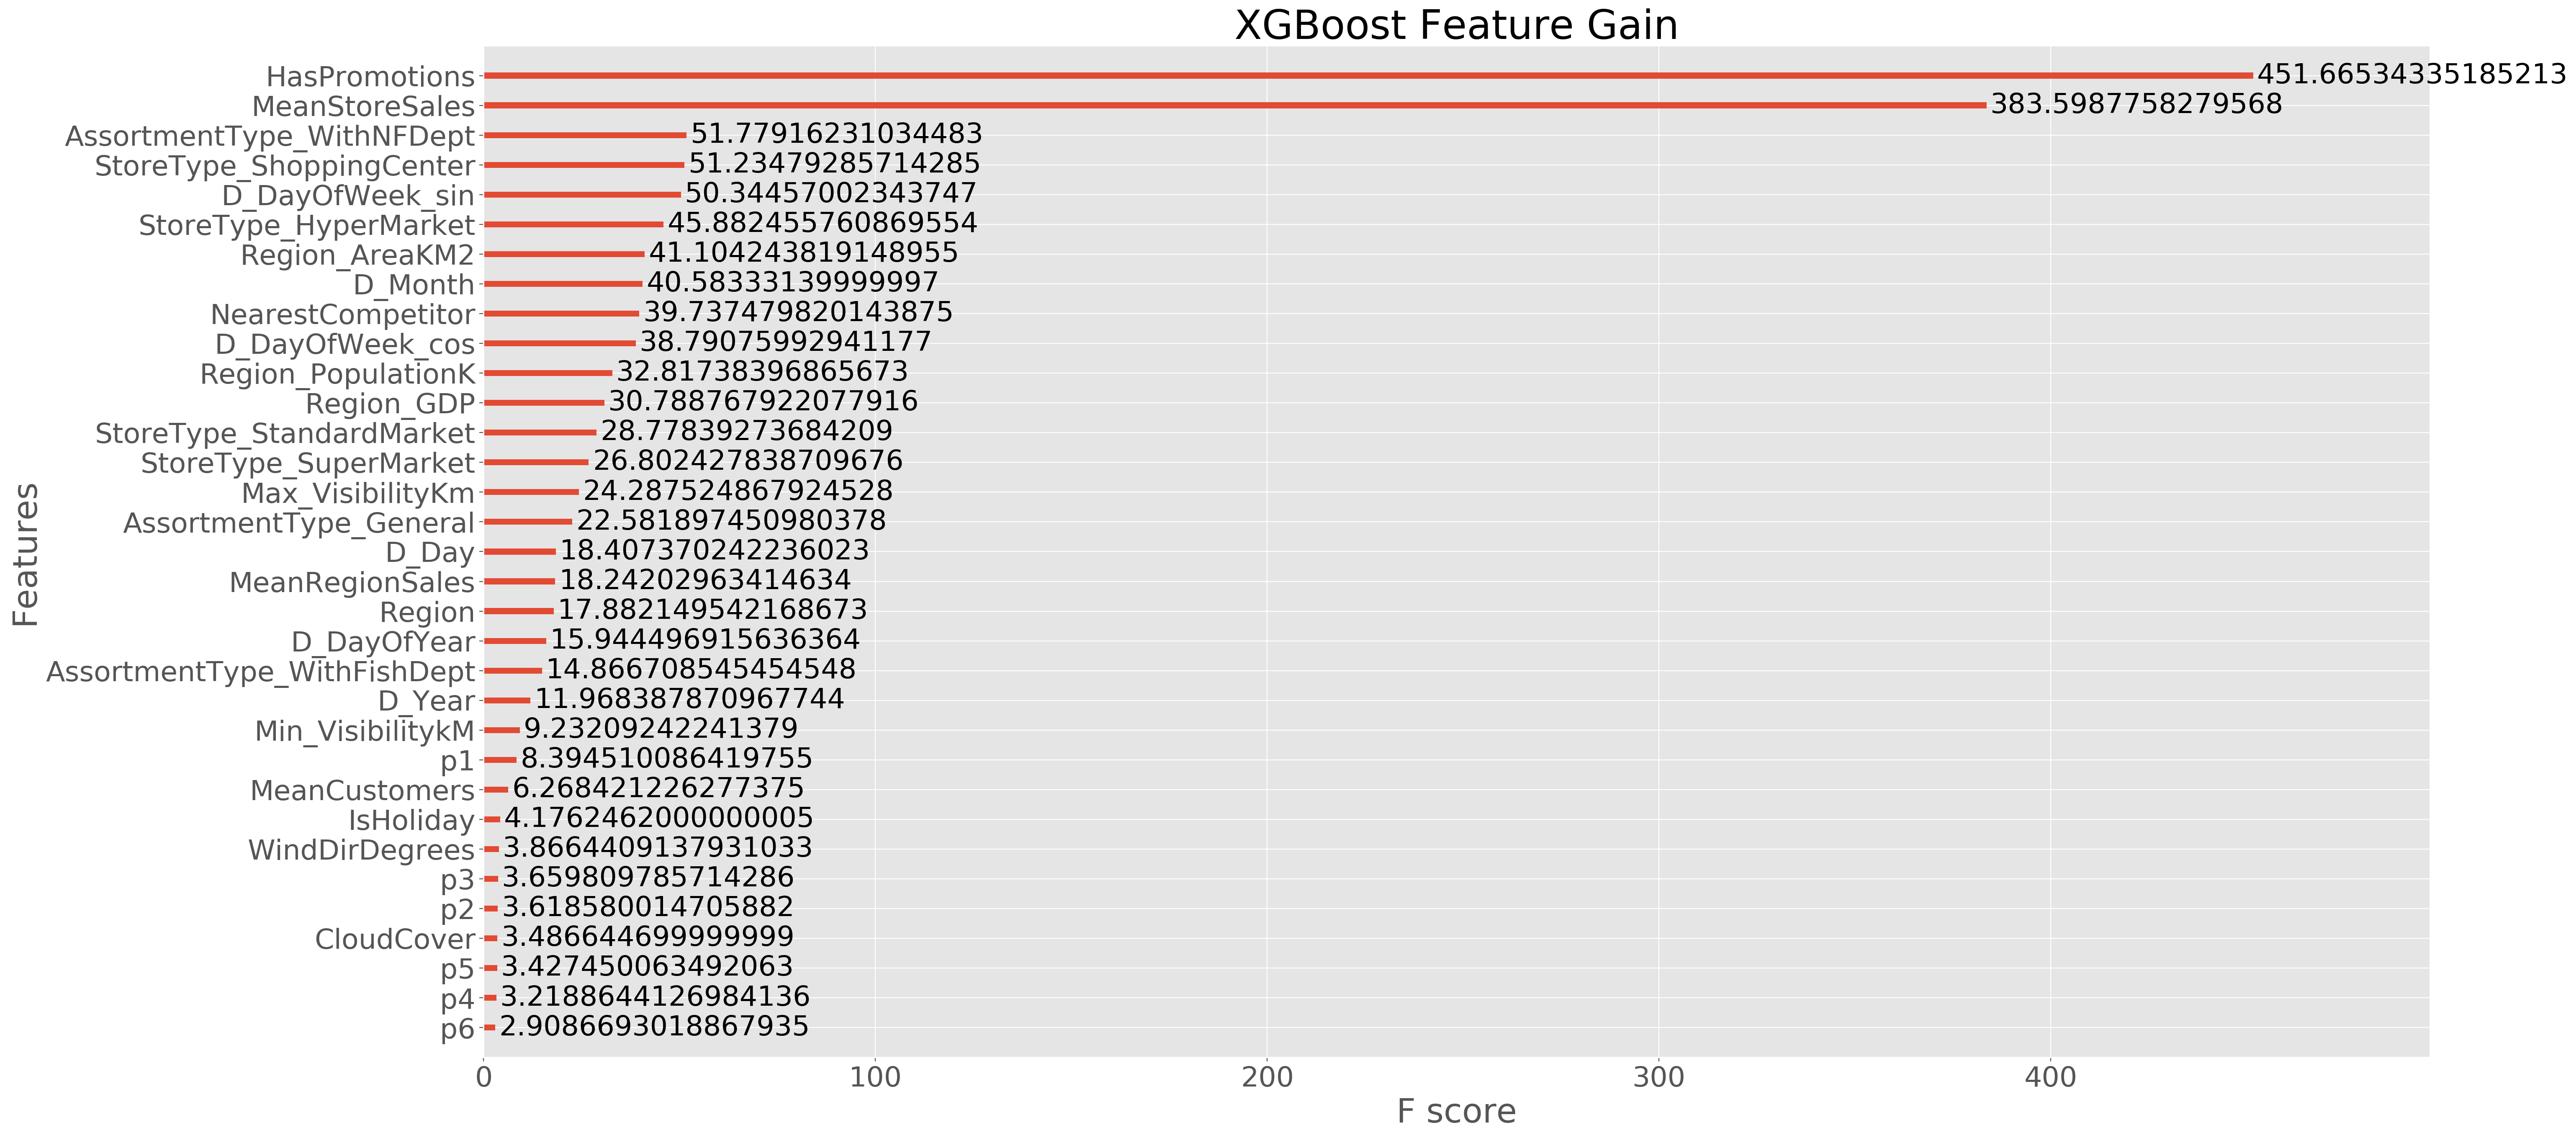

In [19]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

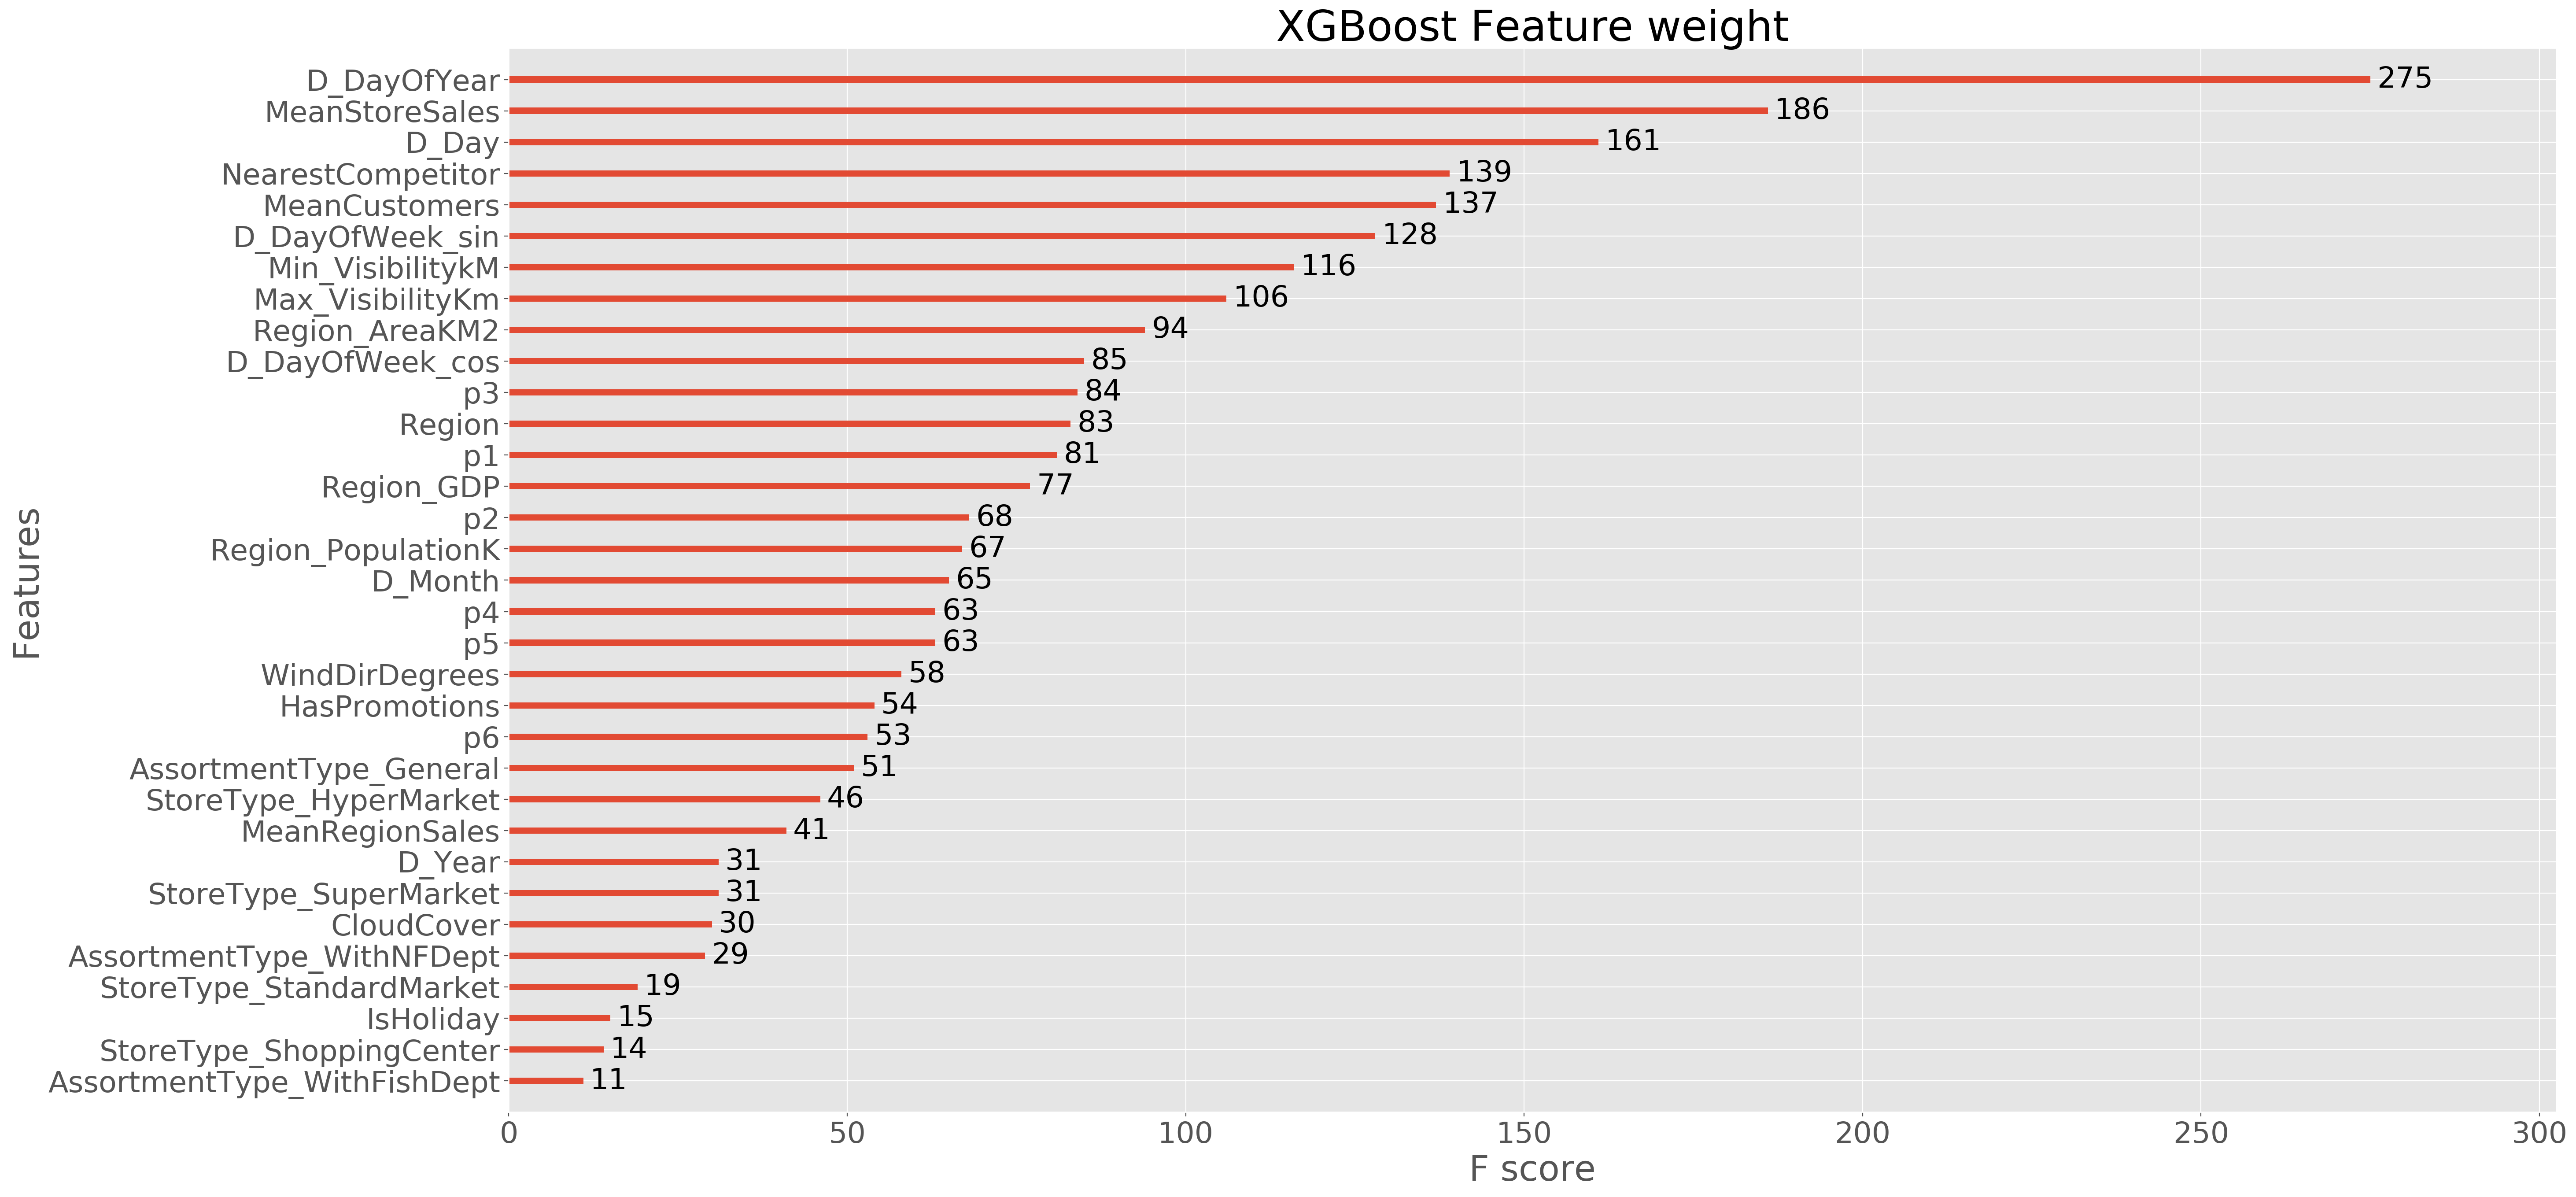

In [20]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

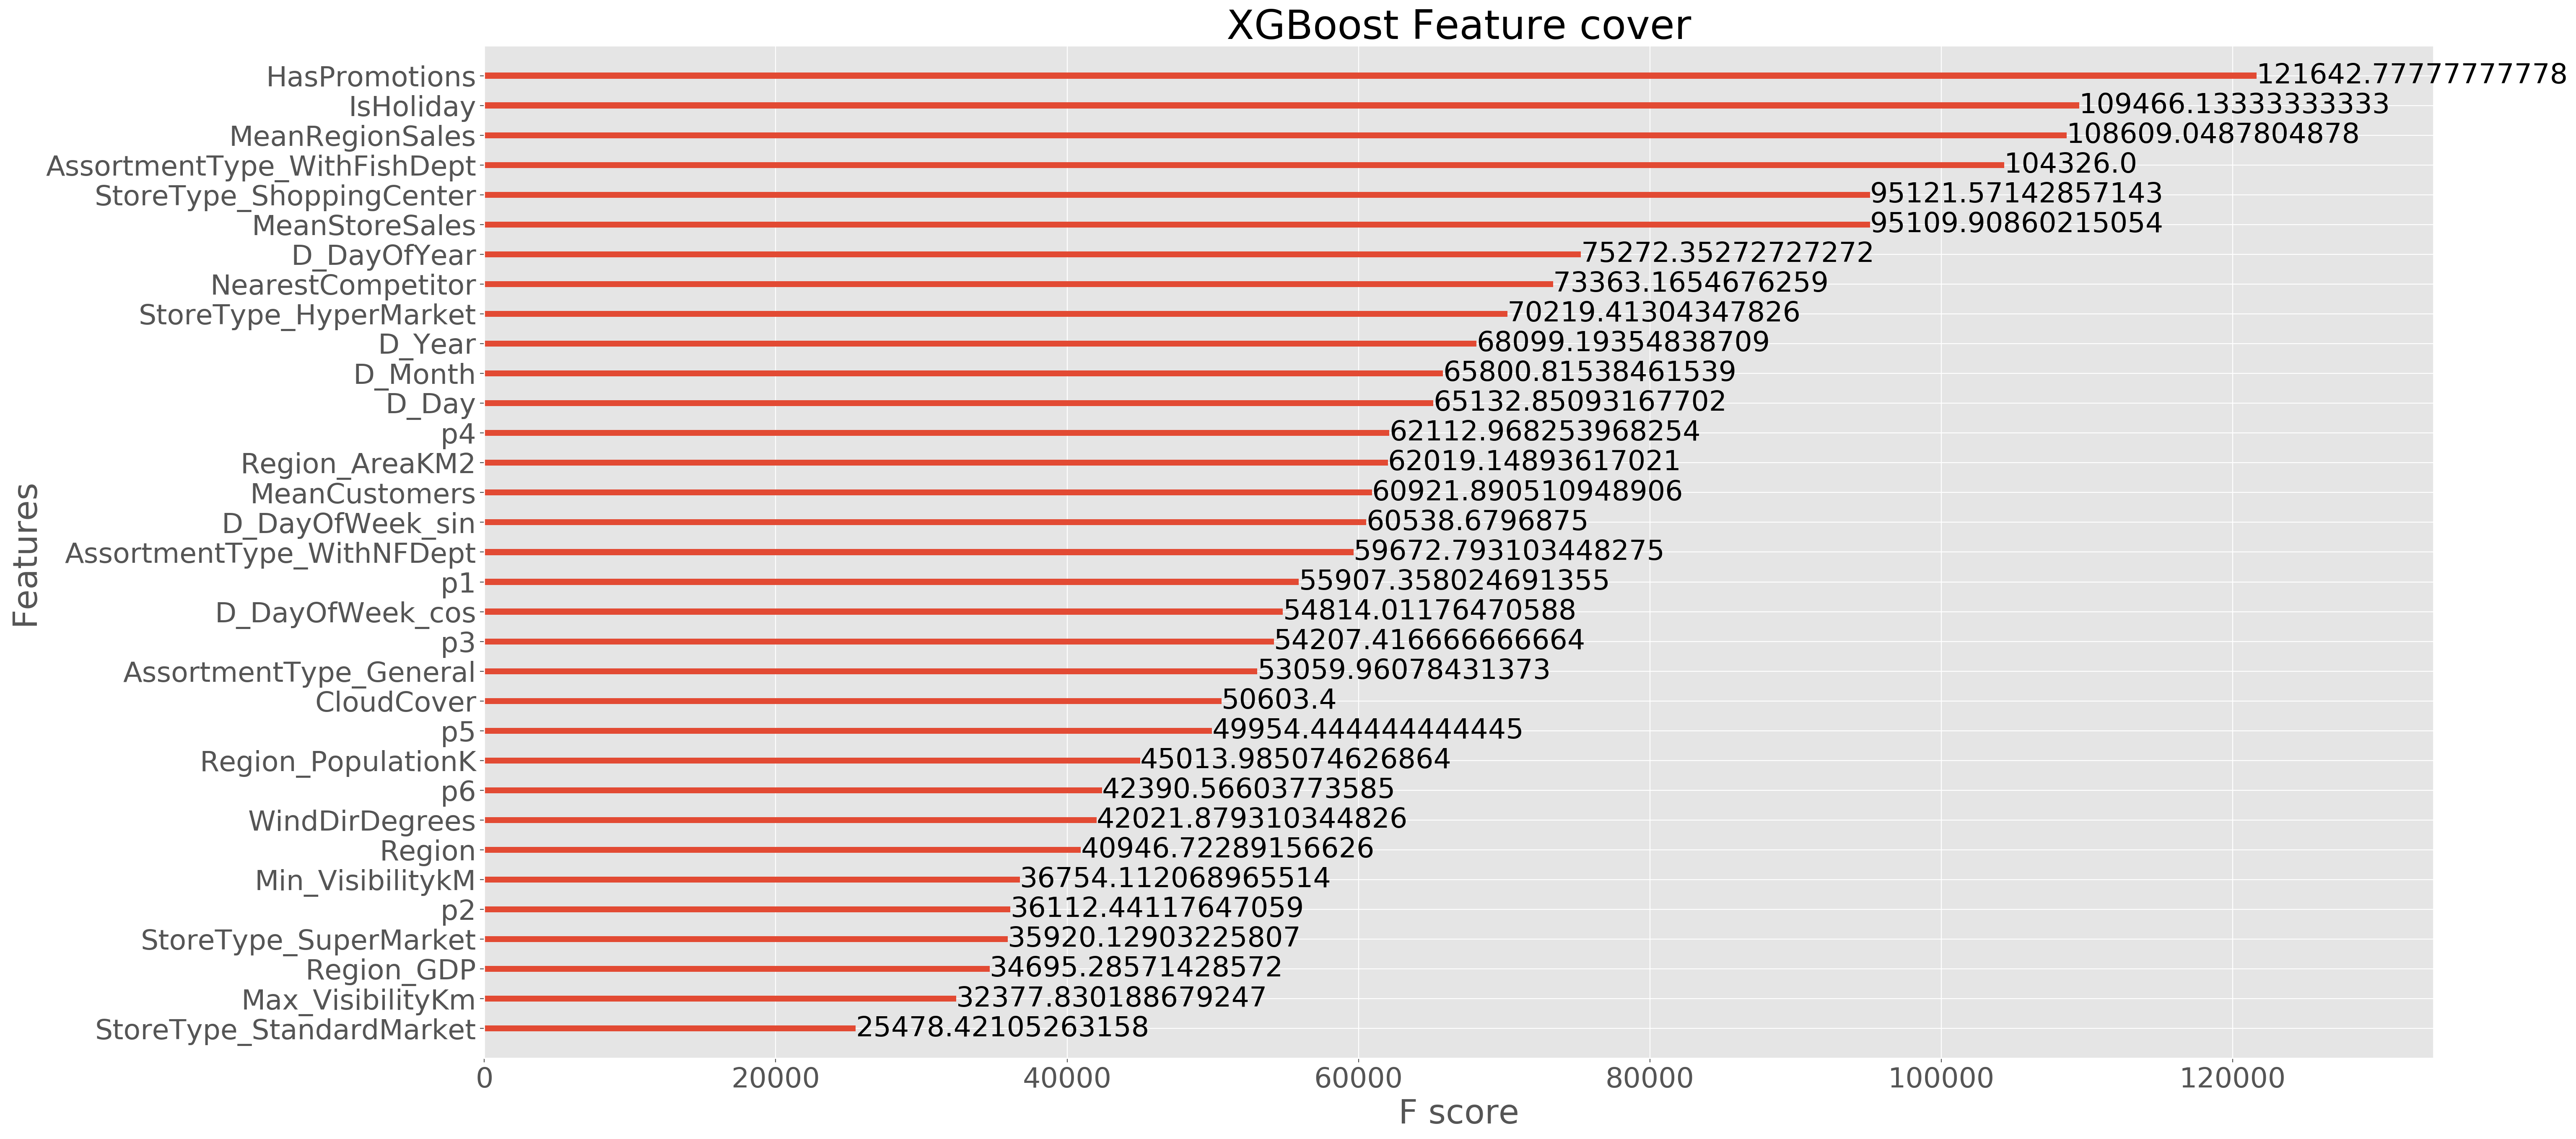

In [21]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [22]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [23]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [24]:
from BIP import get_BIP_error
error1 = get_BIP_error(test)

BIP total error: 0.05008952618136038


## Saving Test

In [25]:
if predict_for_submission:
    test.to_csv('./dataset/submission_test_m34_64_Model_XGBoost_final.csv', index=False)
else:
    test.to_csv('./dataset/test_m12_64_Model_XGBoost_final.csv', index=False)

## Comparing predicted and real
Plotting a sample of predicted and real rows to understand if the prediction is accurate

In [26]:
compare = test[['NumberOfSales','_NumberOfSales']]

In [27]:
compare[1000:1020]

NumberOfSales  _NumberOfSales
12243           5468     6291.676758
12244           6795     4817.338867
12245           7035     8025.495605
12246           5437     6399.964844
12247           5725     6020.792480
12248           5143     5998.328613
12249           5589     6250.434570
12250           7520     4667.646973
12251           3927     4982.274902
12252           3682     4260.433105
12253           3601     4443.321777
12254           3383     4493.407715
12255           4627     4813.242188
12256           7250     4592.571289
12257           7161     7812.034180
12258           6252     6870.078125
12259           5092     6911.155273
12260           6056     5731.559082
12261           6610     7406.539062
12262           6889     5309.048828

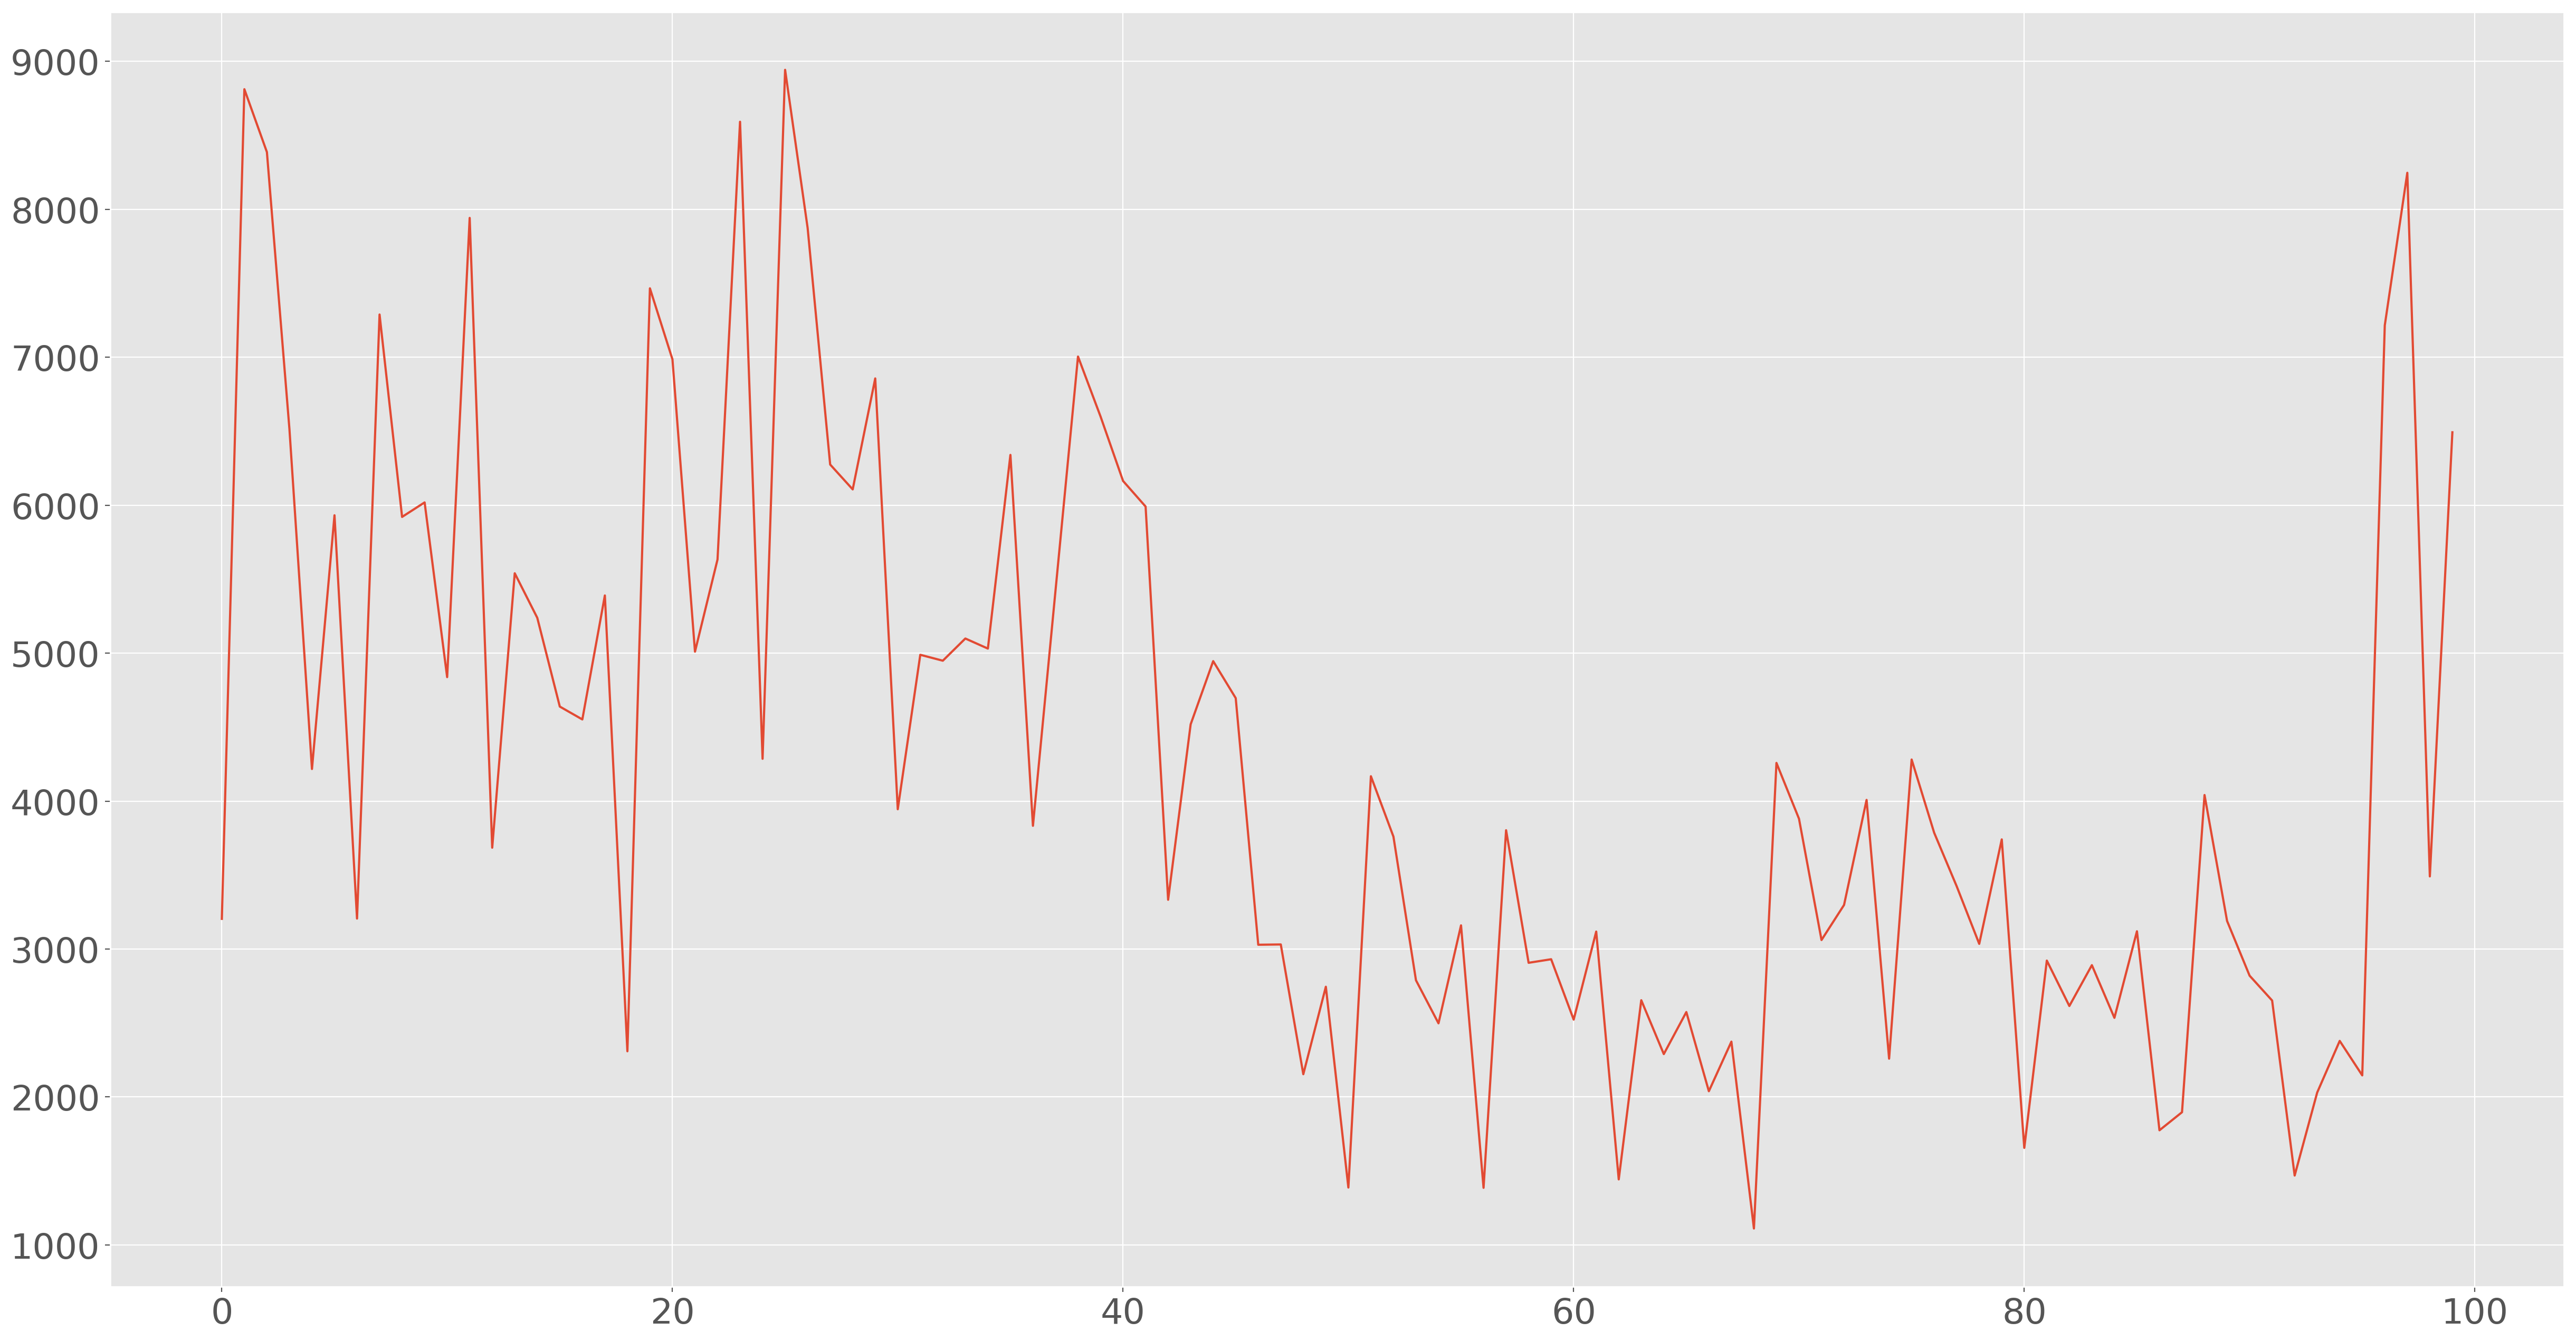

In [28]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

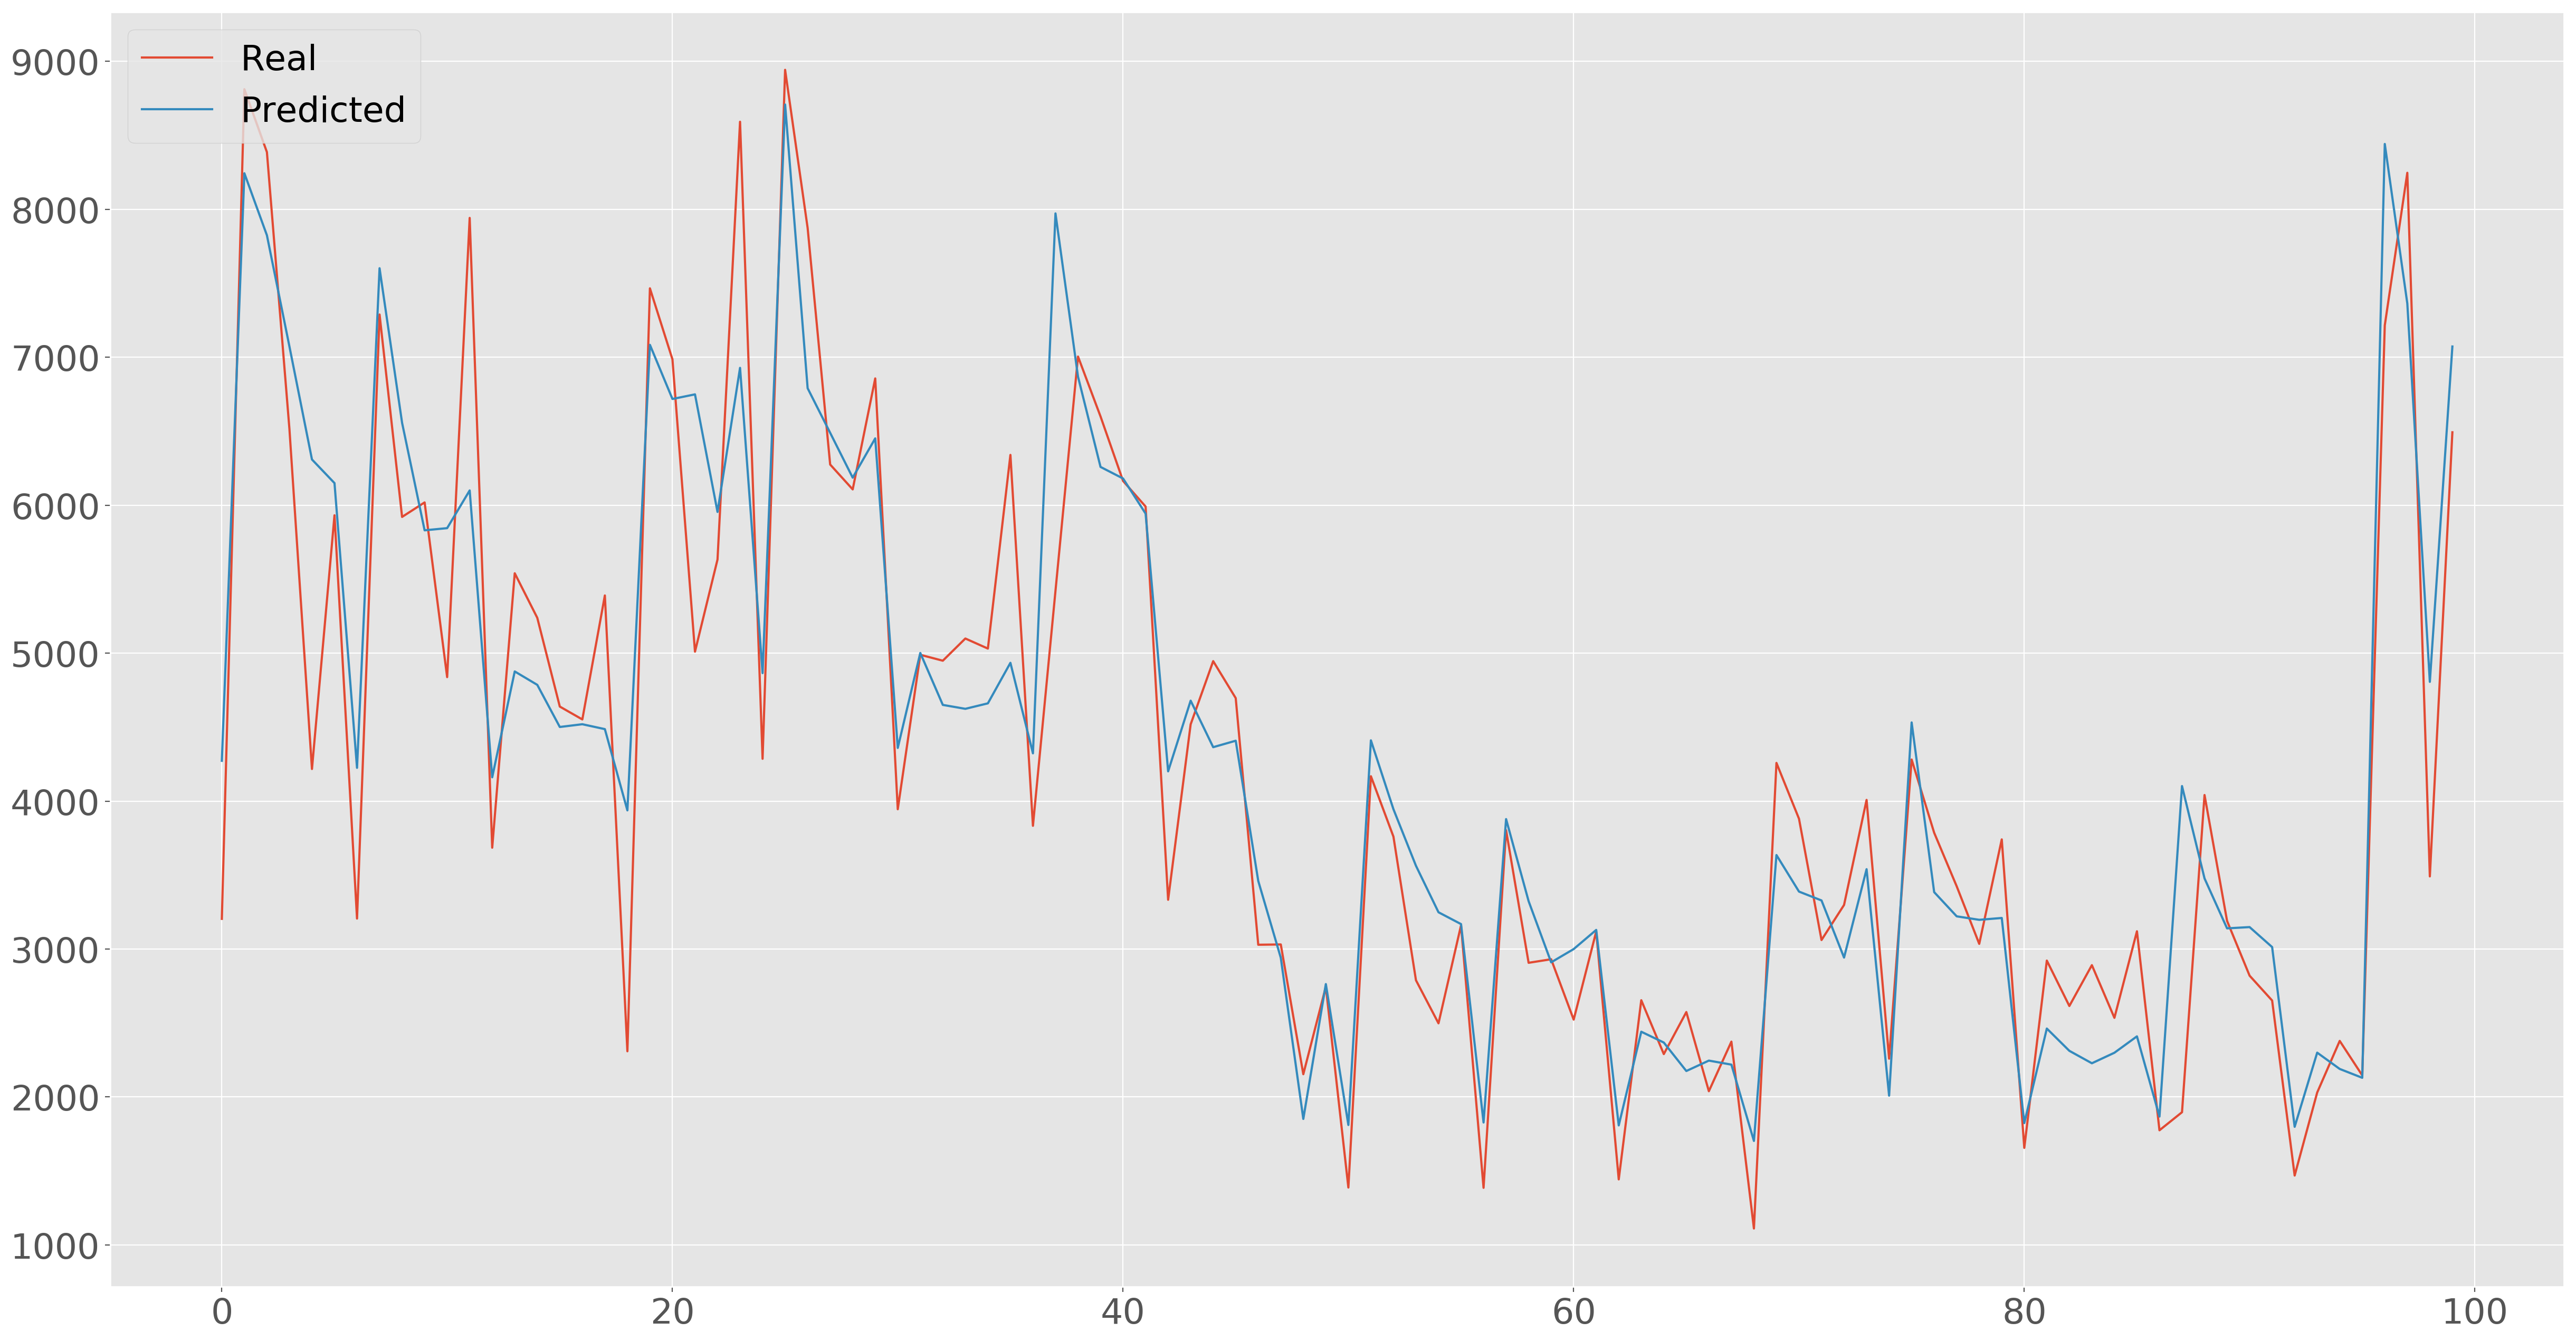

In [29]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

We can notice that the real results has more variance with respect to the predicted ones, this is probably due to the fact that we introduced an important attribute which is the mean sales of a store, this squeezes everything and makes the prediction fall in a small range around the average sales per day, but this is what we want since we don't want to minimize a function that takes into account errors on single days but it looks at the monthly sales.